# Convolutional autoencoder in PyTorch

**[Faisal Z. Qureshi](http://vclab.science.uoit.ca)**  

Check out excellent PyTorch tutorials by "SherlockLiao" at [https://github.com/L1aoXingyu/pytorch-beginner](https://github.com/L1aoXingyu/pytorch-beginner)

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## CUDA support

In [2]:
for i in range(torch.cuda.device_count()):
    print("Found device:", torch.cuda.get_device_name(i))

if torch.cuda.device_count() == 0:
    print("No GPU device found")
else:
    print("Current cuda device is", torch.cuda.get_device_name(torch.cuda.current_device()))

Found device: GeForce GTX TITAN X
Found device: GeForce GTX 980
Current cuda device is GeForce GTX TITAN X


Some helper code that would allow us to use gpu and cpu seemlessly, I think.

In [3]:
class cudafy:
    
    def __init__(self, device=None):
        if torch.cuda.is_available() and device:
            self.device = device
        else:
            self.device = 0
    
    def name(self):
        if torch.cuda.is_available():
            return torch.cuda.get_device_name(self.device)
        return 'Cuda is not available.'
    
    def put(self, x):
        """Put x on the default cuda device."""
        if torch.cuda.is_available():
            return x.to(device=self.device)
        return x

    def __call__(self, x):
        return self.put(x)
    
    def get(self,x):
        """Get from cpu."""
        if x.is_cuda:
            return x.to(device='cpu')
        return x
    
def cpu(x):
    if x.is_cuda:
        return x.to(device='cpu')
    return x

## MNIST Dataset

In [4]:
batch_size = 256

my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('../datasets', transform=my_transforms, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## Autoencoder Model

In [6]:
class autoencoder(nn.Module):
    
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Train

In [7]:
gpu = cudafy()
model = gpu(autoencoder())

learning_rate = 1e-2
weight_decay = 1e-5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)

In [8]:
start_epoch = 1
num_epochs = 10

for epoch in range(start_epoch, start_epoch+num_epochs):
    
    for data in dataloader:        
        img, _ = data # img is a [batch_size, num_channels, 28, 28] tensor
                      # here num_channels is 1
        img = gpu(img)
        
        output = model(img) # Forward
        loss = criterion(output, img)

        optimizer.zero_grad() # Backward & update weights
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch, 
                  start_epoch+num_epochs-1, 
                  loss.data.item()))

pic = to_img(output.cpu().data)
save_image(pic, 'images/image-conv_{}.png'.format(epoch))

epoch [1/10], loss:0.4649
epoch [2/10], loss:0.4564
epoch [3/10], loss:0.4561
epoch [4/10], loss:0.4646
epoch [5/10], loss:0.4531
epoch [6/10], loss:0.4509
epoch [7/10], loss:0.4763
epoch [8/10], loss:0.4346
epoch [9/10], loss:0.4212
epoch [10/10], loss:0.2752


## Checking out the trained autoencoder

torch.Size([256, 1, 28, 28])


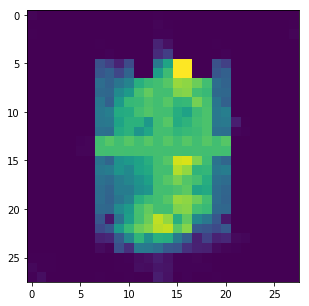

In [11]:
for data in dataloader:
    img, _ = data
    img = gpu(img)
    
    output = model(img)
    
    pic = to_img(output.cpu().data)
    print(pic.shape)
    break
    
plt.figure(figsize=(5,5))
plt.imshow(pic[0,0,:,:])

### Data Preprocessing

Ensure that you do not normalize data.  Since we get the image from dataset itself, the images are already normalized.

torch.Size([1, 28, 28]) tensor(6)
torch.Size([1, 1, 28, 28])


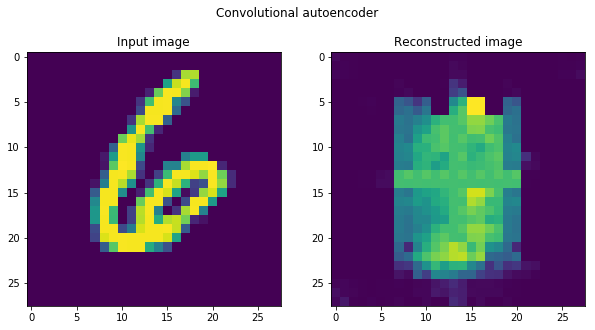

In [12]:
image, label = dataset[13]
print(image.shape, label)

input_img = image
output_img = model(gpu(input_img.unsqueeze(0)))
print(output_img.shape)

plt.figure(figsize=(10,5))
plt.suptitle('Convolutional autoencoder')
plt.subplot(121)
plt.title('Input image')
plt.imshow(image[0])
plt.subplot(122)
plt.title('Reconstructed image')
plt.imshow(output_img[0,0,:,:].cpu().detach())

## Saving the trained model

Now that training is done, it is a good idea to save the trained model.

We will save enough information that would allow us to:

1. Use the trained model; and
2. Retrain the trained model from the place where we left off.

In [13]:
def save_checkpoint(model, optimizer, epoch, filename):
    state = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    try:
        torch.save(state, filename)
        print('Saved checkpoint "{}" (epoch {})'.format(filename, epoch))
    except:
        print('Failed to save checkpoint "{}"'.format(filename))

def load_checkpoint(filename, model, optimizer=None):
    """
    Loads model and optimizer from a file.
    
    If optimizer is None, only loads model.
    """
    import os
    start_epoch = 0
    if os.path.isfile(filename):
        print('Loading checkpoint "{}"'.format(filename))
        try:
            checkpoint = torch.load(filename)
            model.load_state_dict(checkpoint['model'])
            if optimizer:
                start_epoch = checkpoint['epoch']+1
                optimizer.load_state_dict(checkpoint['optimizer'])
            print('Loaded checkpoint "{}" (epoch {})'.format(filename, start_epoch))
        except:
            print('Cannot load checkpoint "{}"'.format(filename))
    else:
        print('Cannot find checkpoint "{}"'.format(filename))
    return model, optimizer, start_epoch

In [14]:
filename = 'conv-ae.pt'
save_checkpoint(model, optimizer, epoch, filename)

Saved checkpoint "conv-ae.pt" (epoch 10)


If we are only interested in saving model weights, we can do the following

In [ ]:
filename = 'conv-ae-weights.pt'
torch.save(model.state_dict(), filename)

## Loading the trained model

Recall that we do not store the structure of the model.  We simply store the weights.  So we will first create the model and then load in the weights.

Since we do not wish to resume training, we  will not load the optimizer.

In [15]:
filename = 'conv-ae.pt'

model2 = gpu(autoencoder())
model2, _, _ = load_checkpoint(filename, model2)

Loading checkpoint "conv-ae.pt"
Loaded checkpoint "conv-ae.pt" (epoch 0)


## Inference

Now lets pass an image through the learned model and see what we get

torch.Size([1, 28, 28]) tensor(6)
torch.Size([1, 1, 28, 28])


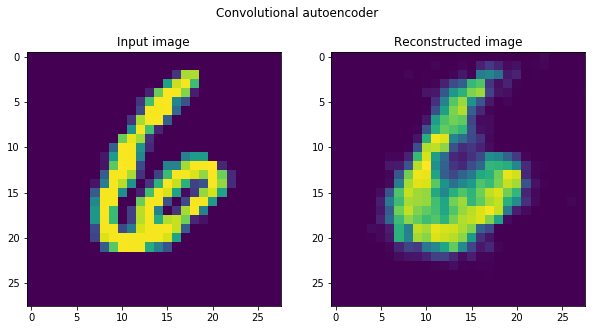

In [16]:
image, label = dataset[13]
print(image.shape, label)

input_img = image
output_img = model2(gpu(input_img.unsqueeze(0)))
print(output_img.shape)

plt.figure(figsize=(10,5))
plt.suptitle('Convolutional autoencoder')
plt.subplot(121)
plt.title('Input image')
plt.imshow(image[0])
plt.subplot(122)
plt.title('Reconstructed image')
plt.imshow(output_img[0,0,:,:].cpu().detach())

## Resume training

We can choose to resume training, by loading the optimizer state as well.

In [22]:
filename = 'conv-ae.pt'

model3 = gpu(autoencoder())
learning_rate = 1e-2
weight_decay = 1e-5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)

model3, optimizer, start_epoch = load_checkpoint(filename, model3, optimizer)

Loading checkpoint "conv-ae.pt"
Loaded checkpoint "conv-ae.pt" (epoch 11)


torch.Size([1, 28, 28]) tensor(6)
torch.Size([1, 1, 28, 28])


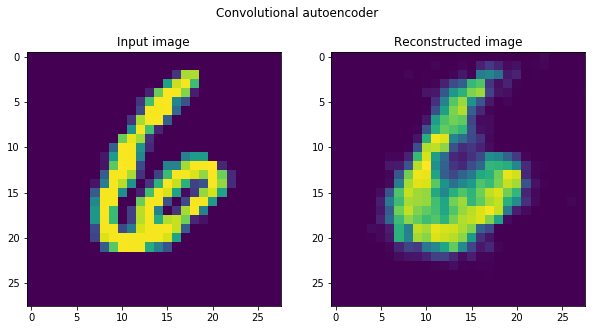

In [23]:
image, label = dataset[13]
print(image.shape, label)

input_img = image
output_img = model3(gpu(input_img.unsqueeze(0)))
print(output_img.shape)

plt.figure(figsize=(10,5))
plt.suptitle('Convolutional autoencoder')
plt.subplot(121)
plt.title('Input image')
plt.imshow(image[0])
plt.subplot(122)
plt.title('Reconstructed image')
plt.imshow(output_img[0,0,:,:].cpu().detach())

In [24]:
num_epochs = 10

for epoch in range(start_epoch, start_epoch+num_epochs):
    
    for data in dataloader:        
        img, _ = data # img is a [batch_size, num_channels, 28, 28] tensor
                      # here num_channels is 1
        img = gpu(img)
        
        output = model3(img) # Forward
        loss = criterion(output, img)

        optimizer.zero_grad() # Backward & update weights
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch, 
                  start_epoch+num_epochs-1, 
                  loss.data.item()))
    
pic = to_img(output.cpu().data)
save_image(pic, 'images/image-conv_{}.png'.format(epoch))

epoch [11/21], loss:0.1198
epoch [12/21], loss:0.1163
epoch [13/21], loss:0.1170
epoch [14/21], loss:0.1205
epoch [15/21], loss:0.1157
epoch [16/21], loss:0.1101
epoch [17/21], loss:0.1096
epoch [18/21], loss:0.1233
epoch [19/21], loss:0.1181
epoch [20/21], loss:0.1136


## Using part of the trained network

Now lets assume we are interested in the encoder bit only.  I.e., we want to pass an MNIST image and wants to get its 3-dimensional encoding.  We can do it as follows.

In [25]:
class my_encoder(nn.Module):
    def __init__(self):
        super(my_encoder, self).__init__()
        
        self.features = nn.Sequential(*list(model3.encoder.children())[:])
    
    def forward(self, x):
        x = self.features(x)
        return x

In [29]:
encoder = my_encoder()
encoding = encoder(gpu(input_img.unsqueeze(0)))
print(cpu(encoding).shape)

torch.Size([1, 8, 2, 2])
